# Research Project - Fine-grained sentiment analysis: SST-5

### **Student:** Ariel Ricardo Ramos Vela



In [1]:
#Install required packages (if needed)
! pip install transformers
! pip install imbalanced-learn
! pip install timebudget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.7 MB/s 
     |████████████████████████████████| 6.6 MB 58.1 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 67.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
#Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import AdamW
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from transformers import RobertaForSequenceClassification, RobertaConfig

from timebudget import timebudget
timebudget.report_atexit()  # Generate report when the program exits

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [3]:
#Load training, validation and testing datasets
train_dataset = pd.read_csv('./train.txt', sep="\t", header=None, names=["label", "data"])
validation_dataset = pd.read_csv('./dev.txt', sep="\t", header=None, names=["label", "data"])
test_dataset = pd.read_csv('./test.txt', sep="\t", header=None, names=["label", "data"])

Text(0, 0.5, 'Label')

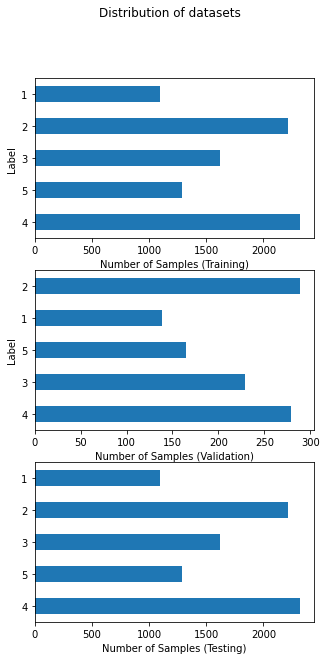

In [4]:
#Explore distribution of datasets

fig, ax = plt.subplots(3, figsize=(5,10))
fig.suptitle('Distribution of datasets')


#Training data

ax[0] = train_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[0])
ax[0].set_xlabel('Number of Samples (Training)')
ax[0].set_ylabel('Label')

# #Validation data
ax[1] = validation_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[1])
ax[1].set_xlabel('Number of Samples (Validation)')
ax[1].set_ylabel('Label')


# #Testing data
ax[2] = train_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[2])
ax[2].set_xlabel('Number of Samples (Testing)')
ax[1].set_ylabel('Label')

In [5]:
#Define architecture of RoBERTa model

class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, n_classes, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        # config = RobertaConfig.from_pretrained('roberta-base')
        # config.num_labels = n_classes
        # self.roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, n_classes)
        
    def forward(self, input_ids, attention_mask):

        # x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)[0]

        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)

        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)

        x = self.l2(x)
        # x = F.softmax(self.l2(x), dim=1)
        return x

In [6]:
#Get the number of classes
n_classes = train_dataset['label'].nunique()
print('N classes: ', n_classes)

model = ROBERTAClassifier(n_classes)

N classes:  5


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
#Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [8]:
def prepare_features(review, zero_pad = False, max_seq_length = 512):
    
    enc_text = tokenizer.encode_plus(text=review, add_special_tokens=True, max_length=max_seq_length, padding='max_length', truncation=True)
    return enc_text

In [9]:
example_review = train_dataset.loc[0]['data']
print(example_review)
enc_example = prepare_features(example_review)
print(enc_example)
print(len(enc_example['input_ids']))

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
{'input_ids': [0, 133, 2751, 16, 19083, 7, 28, 5, 733, 620, 9348, 128, 29, 92, 45518, 38650, 12801, 8, 14, 37, 128, 29, 164, 7, 146, 10, 17158, 190, 2388, 87, 11816, 28797, 2156, 5363, 12, 11428, 5247, 3415, 8234, 1794, 50, 5031, 1608, 9487, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [10]:
#Class to prepare X and Y data
class Format_Data(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):

        review = self.data['data'].iloc[index]

        X = prepare_features(review)

        #Transform current classes [1,2,3,4,5] to [0,1,2,3,4]
        y = self.data['label'].iloc[index] - 1
        
        return np.array(X['input_ids']), np.array(X['attention_mask']), np.array(y)
    
    def __len__(self):
        return self.len

In [11]:
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(validation_dataset.shape))


TRAIN Dataset: (8544, 2)
VALIDATION Dataset: (1101, 2)


In [12]:
print("TEST Dataset: {}".format(test_dataset.shape))

TEST Dataset: (2210, 2)


In [13]:
training_set = Format_Data(train_dataset)
validation_set = Format_Data(validation_dataset)


x, m, y = training_set.__getitem__(820)
print(x.shape)
print(m.shape)
print(y.shape)

(512,)
(512,)
()


In [14]:
print(training_set)

In [15]:
testing_set = Format_Data(test_dataset)

In [16]:
### Dataloaders Parameters
params = {'batch_size': 8}


In [17]:
training_loader = DataLoader(training_set, **params)
validation_loader = DataLoader(validation_set, **params)


In [18]:
testing_loader = DataLoader(testing_set, **params)

In [19]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-5
optimizer = optim.AdamW(params=model.parameters(), betas=(0.9, 0.98), lr=learning_rate)

if torch.cuda.is_available():
    print("GPU is AVAILABLE!🤘🙌💪")
    model = model.cuda()

GPU is AVAILABLE!🤘🙌💪


In [20]:
@timebudget
def train(model, epochs):
  best_accuracy = 0.0 
  max_epochs = epochs
  for epoch in tqdm_notebook(range(max_epochs)):

      train_loss = 0.0
      model.train()
      correct = 0
      total = 0
      for i, (ids, attention_mask, labels) in enumerate(training_loader):

          optimizer.zero_grad()
          if torch.cuda.is_available():
              ids = ids.cuda()
              attention_mask = attention_mask.cuda()
              labels = labels.cuda()

          output = model.forward(ids, attention_mask=attention_mask)

          loss = loss_function(output, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          #Output acc every 100
          _, predicted = torch.max(output, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          accuracy = 100.00 * correct / total

          if i%100 == 0:
              print('Iteration: {}. Loss: {}. Training Accuracy: {}.%'.format(i, loss.item(), accuracy))

      #Calculate training accuracy and loss
      final_t_accuracy = 100.00 * correct / total
      avg_t_loss = train_loss / len(training_loader)
        
      #Validation loop
      valid_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          model.eval()
          for i, (ids, attention_mask, labels) in enumerate(validation_loader):

              if torch.cuda.is_available():
                  ids = ids.cuda()
                  attention_mask = attention_mask.cuda()
                  labels = labels.cuda()
          
              output = model.forward(ids, attention_mask=attention_mask)
              loss = loss_function(output, labels)
              valid_loss += loss.item()

              _, predicted = torch.max(output, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              accuracy = 100.00 * correct / total

              if i%100 == 0:
                  print('Iteration: {}. Loss: {}. Validation Accuracy: {}.%'.format(i, loss.item(), accuracy))

      #Calculate validation accuracy and loss
      final_v_accuracy = 100.00 * correct / total
      avg_v_loss = valid_loss / len(validation_loader)

      #Report results per epoch
      print(f'Epoch {epoch} \t Training Loss: {avg_t_loss} \t Training Accuracy: {final_t_accuracy} \t Validation Loss: {avg_v_loss} \t Validation Accuracy: {final_v_accuracy}')

      # Save the model if the accuracy is the best 
      if final_v_accuracy > best_accuracy: 
            print(f'Accuracy increased({best_accuracy:.6f}--->{final_v_accuracy:.6f}) \t Saving The Model')
            best_accuracy = final_v_accuracy
            torch.save(model.state_dict(), './mymodel.pt')                    
  
  return "Training finished!"

In [21]:
train(model, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/5 [00:00<?, ?it/s]

Iteration: 0. Loss: 1.8542109727859497. Training Accuracy: 12.5.%
Iteration: 100. Loss: 1.4482367038726807. Training Accuracy: 44.306930693069305.%
Iteration: 200. Loss: 1.2202147245407104. Training Accuracy: 47.014925373134325.%
Iteration: 300. Loss: 1.1032936573028564. Training Accuracy: 47.75747508305648.%
Iteration: 400. Loss: 0.996888279914856. Training Accuracy: 49.3142144638404.%
Iteration: 500. Loss: 1.6028183698654175. Training Accuracy: 50.29940119760479.%
Iteration: 600. Loss: 1.2058916091918945. Training Accuracy: 48.0865224625624.%
Iteration: 700. Loss: 1.4000910520553589. Training Accuracy: 48.19900142653352.%
Iteration: 800. Loss: 1.2461833953857422. Training Accuracy: 47.83083645443196.%
Iteration: 900. Loss: 1.3502720594406128. Training Accuracy: 48.18257491675916.%
Iteration: 1000. Loss: 1.3377923965454102. Training Accuracy: 48.489010989010985.%
Iteration: 0. Loss: 1.4708030223846436. Validation Accuracy: 37.5.%
Iteration: 100. Loss: 1.2627463340759277. Validation Ac

'Training finished!'

In [22]:
#Load best model
model.load_state_dict(torch.load('./mymodel.pt'))
model.eval()

ROBERTAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [28]:
#Testing
y_test = []
y_pred = []

correct = 0
total = 0
for i, (ids, attention_mask, labels) in enumerate(testing_loader):
    if torch.cuda.is_available():
        ids = ids.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()
    
    output = model.forward(ids,attention_mask=attention_mask)

    _, predicted = torch.max(output, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = 100.00 * correct / total

    y_test.extend(labels.tolist())
    y_pred.extend(predicted.tolist())

    if i%100 == 0:      
        print('Iteration: {}. Accuracy: {}%'.format(i, accuracy))


accuracy = 100.00 * correct / total
print('Final Accuracy: ', accuracy)

Iteration: 0. Accuracy: 75.0%
Iteration: 100. Accuracy: 59.15841584158416%
Iteration: 200. Accuracy: 55.03731343283582%
Final Accuracy:  53.16742081447964


In [29]:
print(y_test)
print(y_pred)

[2, 3, 4, 2, 4, 3, 3, 3, 3, 4, 3, 3, 4, 2, 3, 2, 4, 3, 4, 4, 4, 2, 3, 3, 3, 3, 3, 1, 3, 4, 4, 2, 3, 3, 1, 3, 3, 3, 1, 2, 4, 0, 4, 4, 3, 2, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 1, 3, 4, 4, 4, 4, 2, 4, 4, 4, 3, 1, 4, 3, 3, 2, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 1, 3, 0, 3, 3, 4, 2, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 2, 2, 4, 3, 2, 4, 3, 1, 3, 2, 3, 4, 4, 4, 2, 3, 3, 4, 3, 3, 1, 4, 4, 3, 4, 3, 4, 3, 3, 4, 3, 1, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 1, 4, 4, 4, 1, 4, 3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 3, 2, 4, 4, 4, 3, 4, 2, 3, 4, 4, 0, 4, 3, 3, 3, 2, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 2, 4, 3, 4, 3, 4, 4, 3, 2, 4, 3, 2, 1, 3, 4, 4, 3, 3, 4, 4, 1, 4, 4, 2, 4, 4, 3, 4, 2, 4, 3, 1, 2, 4, 3, 3, 2, 3, 4, 2, 3, 3, 4, 2, 4, 3, 2, 2, 3, 3, 1, 2, 3, 4, 4, 4, 2, 4, 3, 4, 3, 2, 2, 4, 4, 3, 4, 2, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 2, 4, 3, 3, 1, 4, 3, 4, 4, 4, 4, 4, 3, 3, 1, 4, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 4, 4, 2, 2, 2, 3, 4, 3, 4, 3, 4, 

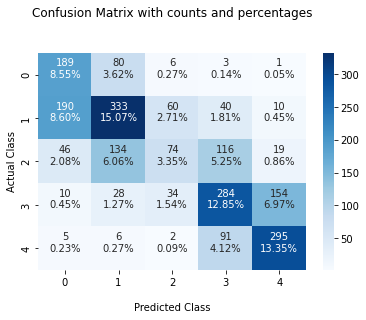

In [30]:
#Compute confusion matrix and plot it
cf_matrix = confusion_matrix(y_test, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with counts and percentages\n\n');
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('Actual Class');

## Display the visualization of the Confusion Matrix.
plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.68      0.53       279
           1       0.57      0.53      0.55       633
           2       0.42      0.19      0.26       389
           3       0.53      0.56      0.54       510
           4       0.62      0.74      0.67       399

    accuracy                           0.53      2210
   macro avg       0.51      0.54      0.51      2210
weighted avg       0.53      0.53      0.52      2210

